## Colab: install deps

In [1]:
if 'google.colab' in str(get_ipython()):
    !yes | pip install git+https://github.com/mattclifford1/CLIME/ -qqq > /dev/null
%load_ext autoreload
%autoreload 2
import clime
from clime.utils.notebooks import *

# Pipeline for CLIME: Cost-sensitive LIME 

# Pipeline Options

In [2]:
data_store = get_pipeline_widgets()

synthetic datasets


IntRangeSlider(value=(25, 75), description='CLASS SAMPLES (synthetic datasets):', max=200, min=1)

real datasets


FloatSlider(value=0.1, description='PERCENT DATA (real datasets):', max=10.0, min=0.01)

ToggleButtons(description='DATASET:', options=('moons', 'guassian', 'credit scoring 1', 'credit scoring 2', 'd…

ToggleButtons(description='DATASET REBALANCING:', options=('none', 'oversampling'), value='none')

ToggleButtons(description='MODEL:', options=('SVM', 'SVM balanced training'), value='SVM')

ToggleButtons(description='MODEL BALANCER:', options=('boundary adjust', 'probability adjust', 'none'), value=…

ToggleButtons(description='EXPLAINER:', options=('bLIMEy (normal)', 'bLIMEy (cost sensitive training)', 'bLIME…

ToggleButtons(description='EVALUATION:', options=('fidelity (normal)', 'fidelity (local)', 'fidelity (class ba…

# RUN

In [3]:
# run pipeline visulation 
get_run_button()

Button(description='RUN PIPELINE', style=ButtonStyle())

# Visualise

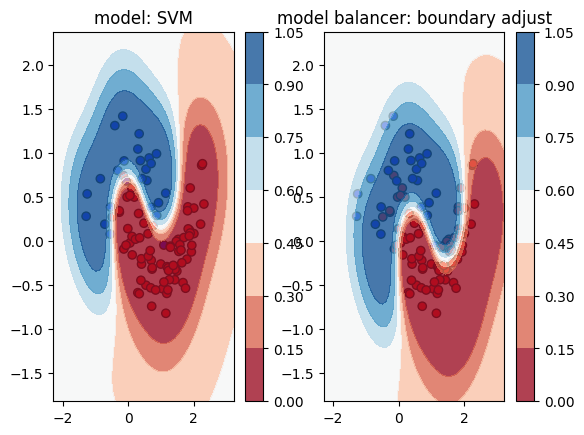

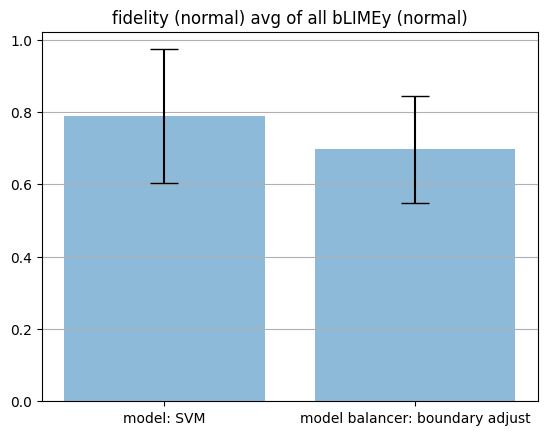

In [4]:
run_vis_pipeline(data_store)